# Figure 1. Summary of the simulation setup.

[Skip code and jump to the figure](#Show-the-figure)

In [1]:
import cartopy.crs as ccrs
import iris
import matplotlib.colors as mcol
import matplotlib.pyplot as plt
import numpy as np
import swiftascmaps
from aeolus.io import load_data
from aeolus.plot import figsave, subplot_label_generator
from matplotlib.offsetbox import AnchoredText

In [2]:
# Local modules
import paths
from common import CONST, N_RES, SIMULATIONS, all_sim_file_label
from cubed_sphere_transforms import add_panels_cart

In [3]:
# Show all simulations
show_sim = [*SIMULATIONS.keys()]

In [4]:
# Define a function to print simulation details
def make_summary(sim, sep=":", line_sep="\n"):
    """Summarise simulation details."""
    dx = 2 * np.pi * CONST.radius.data * 1e-3 / (sim.c_num * 4)
    dx_min, dx_max = dx / sim.stretch_factor, dx * sim.stretch_factor
    if sim.stretch_factor == 1:
        cell_width_str = f"{dx:.0f}"
    else:
        cell_width_str = f"{dx_min:.1f}-{dx_max:.0f}"

    sim_summary_dict = {
        "Stretch factor": sim.stretch_factor,
        "Approximate cell width (km)": cell_width_str,
        "Convection parameterization": sim.convection_parameterization,
    }
    max_len = 0
    for key in sim_summary_dict:
        max_len = max(max_len, max(len(i) for i in key.split("\n")))
        #:<{max_len}
    sim_summary = line_sep.join(
        f"{key}{sep}{value}" for key, value in sim_summary_dict.items()
    )
    return sim_summary


# test
print(make_summary(SIMULATIONS[show_sim[0]], sep=" : "))

Stretch factor : 10
Approximate cell width (km) : 4.7-474
Convection parameterization : None


## Load regridded and time-averaged data

In [5]:
dset = {}
for sim_label in show_sim:
    dset[sim_label] = load_data(
        paths.data_proc
        / SIMULATIONS[sim_label].work_name
        / f"{SIMULATIONS[sim_label].work_name}_inst_diag_*_time_mean_and_regr_{N_RES}.nc".lower()
    )

## Make the plot

In [6]:
# levels = [5, 10, 47, 100, 200, 400]
c_num = 12

fig = plt.figure(figsize=(8, 2), layout="constrained")
# fig.suptitle(f"Grid Cell Size [km]", fontweight="bold")
# mosaic = [show_sim, [f"{i}-cax" for i in show_sim]]
# mosaic = [show_sim + ["cax"]]
mosaic = [show_sim]
axd = fig.subplot_mosaic(
    mosaic,
    # height_ratios=[1, 0.05],
    # width_ratios=[1, 1, 1, 1, 0.05],
    per_subplot_kw={
        sim_label: dict(projection=ccrs.Orthographic(20, 10)) for sim_label in show_sim
    },
)

iletters = subplot_label_generator()
for sim_label in show_sim:
    ax = axd[sim_label]
    ax.set_title(
        f"({next(iletters)})",
        loc="left",
        fontdict={"weight": "bold"},
        pad=3,
    )
    ax.set_title(
        SIMULATIONS[sim_label].title,
        loc="center",
        fontdict={"weight": "bold"},
        pad=3,
        color=SIMULATIONS[sim_label].kw_plt["color"],
    )
    cube = dset[sim_label].extract_cube("cell_area") ** 0.5
    cube.convert_units("km")
    y, x = cube.dim_coords
    h0 = ax.pcolormesh(
        x.points,
        y.points,
        cube.data,
        cmap=swiftascmaps.nineteen_eighty_nine_tv,
        norm=mcol.TwoSlopeNorm(vcenter=47, vmin=4.7, vmax=470),
        transform=ccrs.PlateCarree(),
        rasterized=True,
    )
    # cbar = fig.colorbar(h0, cax=axd[f"{sim_label}-cax"], orientation="horizontal")
    # cbar = fig.colorbar(h0, cax=axd["cax"], orientation="vertical")
    # cbar.set_ticks([4.7, 47, 470])
    # cbar.set_ticklabels(["4.7", "47", "470"])
    # cbar.set_label("Grid Cell Size [km]", fontweight="bold")

    # h1 = ax.contour(
    #     x.points,
    #     y.points,
    #     cube.data,
    #     levels=levels,
    #     colors=SIMULATIONS[sim_label].kw_plt["color"],
    #     linewidths=0.5,
    #     transform=ccrs.PlateCarree(),
    # )
    # ax.clabel(h1, fmt="%.0f")
    # ax.coastlines()
    add_panels_cart(
        ax,
        c_num,
        0,
        0,
        stretch_factor=SIMULATIONS[sim_label].stretch_factor,
        color=SIMULATIONS[sim_label].kw_plt["color"],
        transform=ccrs.PlateCarree(),
    )

    ax.plot(0, 0, transform=ccrs.PlateCarree(), marker=".", ms=3, color="k")

    at = AnchoredText(
        make_summary(SIMULATIONS[sim_label], sep=": "),
        loc="lower center",
        borderpad=-4,
        frameon=True,
        prop={
            "size": "medium",
            "weight": "bold",
            "horizontalalignment": "left",
            "color": SIMULATIONS[sim_label].kw_plt["color"],
        },
    )
    # at.patch.set_facecolor(mcol.to_rgba("w", alpha=0.85))
    at.patch.set_edgecolor("none")
    ax.add_artist(at)
cbar = fig.colorbar(h0, orientation="vertical", shrink=0.6)
cbar.set_ticks([4.7, 47, 470])
cbar.set_ticklabels(["4.7", "47", "470"])
cbar.set_label("Grid Cell Size [km]", fontweight="bold")

plt.close()

# Show the figure

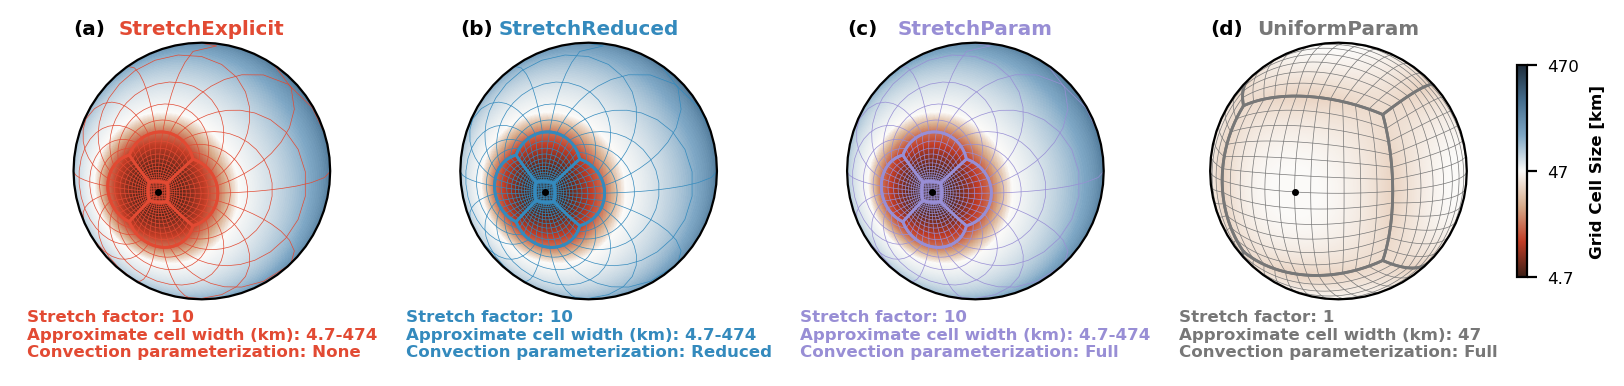

In [7]:
fig

- **Color shading shows the cell width (km) calculated as a square root of the cell area.**
- **All simulations use the C192 mesh.**
- **For clarity, the mesh edges are displayed at a low resolution (C12), so the actual grid cells in our simulations sixteen times smaller.**
- **The black dot shows the location of the substellar point.**
- **For more details on the stretching procedure, see Appendix A.**
- **Here and throughout the paper, the experiments are color-coded: _StretchExplicit_ is shown in red, _StretchReduced_ in blue, _StretchParam_ in purple, and _UniformParam_ in gray.**

In [8]:
# and save it
figsave(
    fig,
    paths.figures
    / f"regr__{all_sim_file_label(show_sim)}__cell_width__c{c_num}_mesh__summary",
)

Saved to ../figures/regr__hab1_mod_c192_s10e_s10r_s10p_p__cell_width__c12_mesh__summary.pdf
